In [20]:
%config InlineBackend.figure_format = 'svg'
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skylark import skylark_root, MB, GB

base_dir = skylark_root / "data" / "experiments" / "benchmark_triangles"

In [21]:
configs = list((base_dir / "logs").glob("*"))

rows = []
for config in configs:
    for f in (skylark_root / "data" / "experiments" / "benchmark_triangles" / config / "results").glob("*.pkl"):
        with open(f, "rb") as fp:
            result = pickle.load(fp)
        rows.append(result)
df = pd.DataFrame(rows)
df_orig = df.copy()

if "error" in df.columns:
    for row in df[df.error.notnull()].itertuples():
        print(f"{row.src_region} -> {row.dst_region} -> {row.inter_region}: {row.error}")
    df = df[df.error.isnull()]

aws:sa-east-1 -> aws:us-west-2 -> aws:eu-west-1: name 'pbar' is not defined


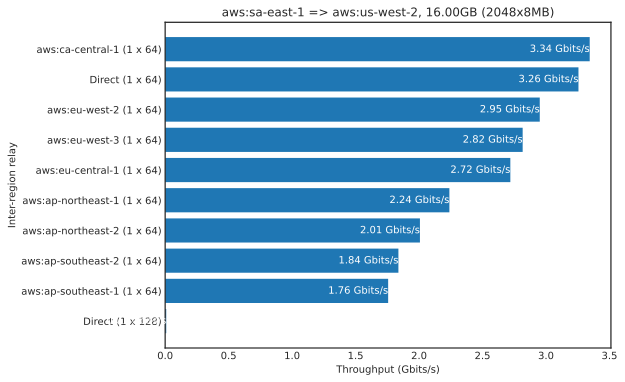

In [22]:
for (src, dst), group_df in df.groupby(["src_region", "dst_region"]):
    group_df = group_df.reset_index(drop=True)
    group_df = group_df[(group_df.inter_region != src) & (group_df.inter_region != dst)]

    # sort by throughput_gbits
    group_df = group_df.sort_values(by="throughput_gbits", ascending=True)
    group_df["inter_region"] = group_df.inter_region.fillna("Direct")
    group_df["label"] = group_df.apply(lambda row: f"{row.inter_region} ({row.num_gateways} x {row.num_outgoing_connections})", axis=1)
    group_df["transfer_bytes"] = group_df.apply(lambda row: row.n_chunks * row.chunk_size_mb * MB, axis=1)
    assert np.all(group_df.transfer_bytes == group_df.transfer_bytes[0])

    # plot barh
    # title = f"Skylark throughput {src} => {dst}, {group_df.transfer_bytes[0] / GB:.2f}GB in group_df.num_chunks[0]x group_df.chunk_size_mb[0]MB chunks"
    with plt.style.context(["seaborn-white", {"font.size": 10}]):
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.barh(
            group_df.label,
            group_df.throughput_gbits,
        )
        ax.set_xlabel("Throughput (Gbits/s)")
        ax.set_ylabel("Inter-region relay")
        ax.set_title(f"{src} => {dst}, {group_df.transfer_bytes[0] / GB:.2f}GB ({group_df.n_chunks[0]}x{group_df.chunk_size_mb[0]}MB)")

        # add white labels to each bar
        for i, (label, throughput) in enumerate(zip(group_df.label, group_df.throughput_gbits)):
            # assert i, throughput not NaN
            if not np.isnan(throughput):
                ax.text(
                    throughput,
                    i,
                    f"{throughput:.2f} Gbits/s",
                    ha="right",
                    va="center",
                    color="white",
                )